Predefined libraries that are required

In [0]:
%%capture
# Install the latest Tensorflow version.
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub
!pip3 install seaborn
!pip3 install fast-pagerank
!pip3 install rouge

In [0]:
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from fast_pagerank import pagerank
import math
import spacy
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm
import nltk
import nltk.data
from __future__ import division
import gensim
from sklearn.decomposition import PCA
import gensim.models.word2vec
from collections import Counter
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics.pairwise import cosine_similarity
import itertools
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
import csv
from rouge import Rouge

import operator
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize

nltk.download('all')
Stopwords = set(stopwords.words('english'))
wordlemmatizer = WordNetLemmatizer()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')





nlp = spacy.load('en')

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
file_path = '/content/drive/My Drive/NLP_DATA/'
news_summary = pd.read_csv(file_path + 'bbc_dataset.csv' , encoding='ISO-8859-1')

In [0]:
news_summary.head()

,ARTICLE,SUMMARY
0,Ad sales boost Time Warner profit\nQuarterly p...,TimeWarner said fourth quarter sales rose 2% t...
1,Dollar gains on Greenspan speech\nThe dollar h...,The dollar has hit its highest level against t...
2,Yukos unit buyer faces loan claim\nThe owners ...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\nBritish Air...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\nShares in U...,Pernod has reduced the debt it took on to fund...


In [0]:
def embedSentences(messages_):
  message_embeddings_ = embed(messages_)
  similarity_list.append(np.inner(message_embeddings_, message_embeddings_))
  #plot_similarity(messages_, message_embeddings_, 90)

def sortListOnSimilarity(paragraph, similarityScore):
  similarityScore = similarityScore.reshape(-1)
  sorted_index = np.argsort(similarityScore)
  sorted_index = sorted_index.reshape(-1)
  dummy_list = []
  lengthScore = len(similarityScore)
  for iter in range(lengthScore):
    dummy_list.append(paragraph[sorted_index[iter]])
  new_list = ""
  #the number of sentences to be considered is subject to changes
  numberOfSentencesRequired = 10 if math.ceil(lengthScore / 2) > 10 else math.ceil(lengthScore / 2)
  for iter in range(numberOfSentencesRequired):
    new_list = new_list + dummy_list[lengthScore - iter - 1] + " "
  return new_list

def plot_graph(oneList,twoList, LenList):
  plt.plot(oneList, linestyle='-', color='g', label='Rouge 1')
  plt.plot(twoList, linestyle=':', color='r', label='Rouge 2')
  plt.plot(LenList, linestyle='-', color='b', label='Rouge 3')
  plt.legend(loc='best')
  plt.xlabel("Data")
  plt.ylabel("F-Measure")


  x_keys = ["1" , "2" , "l"]
  print("Mean values",np.mean(oneList) , np.mean(twoList) , np.mean(LenList))
  y_vales = [ np.mean(oneList) , np.mean(twoList) , np.mean(LenList)]
  plt.style.use('seaborn-whitegrid')
  fig = plt.figure()
  ax = plt.axes()
  ax.plot( x_keys , y_vales)
  plt.xlabel("N-Gram")
  plt.ylabel("Mean F-Measure")

def runPerformanceMetric(dataframe):
  rougeObj = Rouge()
  rougeOneList = []
  rougeSecondList = []
  rougeLenList = []
  for i in tqdm(range(len(dataframe["ORIGINAL_SUMMARY"]))):
    scores = rougeObj.get_scores(dataframe["OUR_SUMMARY"][i], dataframe["ORIGINAL_SUMMARY"][i])
    scores = scores[0]
    rougeOneList.append(scores["rouge-1"]["f"])
    rougeSecondList.append(scores["rouge-2"]["f"])
    rougeLenList.append(scores["rouge-l"]["f"])

  plot_graph(rougeOneList,rougeSecondList, rougeLenList )

Loading Google's Universal Sentence Encoder

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [0]:
output_array = []
for each_news_article in tqdm(news_summary["ARTICLE"]):
  each_news_sentences = []

  # tokenizer with spacy
  # tokens = nlp(each_news_article)
  # for sent in tokens.sents:
  #     each_news_sentences.append(sent.string.strip())
  
  for sent in tokenizer.tokenize(each_news_article):
    each_news_sentences.append(sent)

  similarity_list=[]
  embedSentences(each_news_sentences)
  similarityScore = csr_matrix(np.array(similarity_list)[0])
  rankedList=pagerank(similarityScore, p=0.85)
  output_array.append(sortListOnSimilarity(each_news_sentences,rankedList))

output_pd = pd.DataFrame()
output_pd["OUR_SUMMARY"] = output_array
output_pd["ORIGINAL_SUMMARY"] = news_summary["SUMMARY"]


Mean values 0.7206945432792313 0.6472138627864064 0.7247340302578442


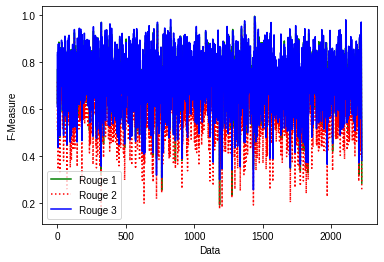

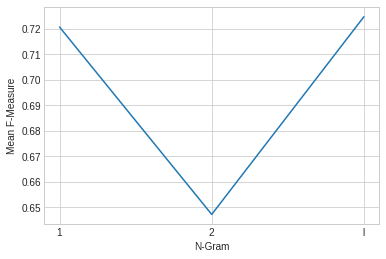

In [0]:
runPerformanceMetric(output_pd)

**TF-IDF Sentence Ranking**


Before summarizing we have to preprocess the raw document. Preprocessing involves lemmatization, stemming and cleaning. The lemmatization function helps to lemmatize the word tokens using the wordlemmatizer. The stemming function is used to separate the main stem of the word token. Then punctuation omitter function helps in cleaning the text by removing the punctuation marks.

In [0]:
def lemmatization(words):
    lemma_text = []
    for word in words:
       lemma_text.append(wordlemmatizer.lemmatize(word))
    return lemma_text

def stemming(inputWords):
    stem_text = []
    for word in inputWords:
       stem_text.append(stemmer.stem(word))
    return stem_text

def punctuation_omitter(word):
    regExpression = r'[^a-zA-Z0-9\s]'
    word = re.sub(regExpression,'',word)
    return word

In [0]:
# The function freq() is used to calculate the frequency of a word in the document
def freq(IpText):
    IpText = [word.lower() for word in IpText]
    frequencyDictionary = {}
    monoTexts = []
    for word in IpText:
       if word not in monoTexts:
           monoTexts.append(word)
    for word in monoTexts:
       frequencyDictionary[word] = IpText.count(word)
    return frequencyDictionary

#The function tagger() is used to tag each word with it is corressponding POS tag. This function returns the noun phrases and verb phrases in the document
def tagger(word):
    tags = nltk.pos_tag(word.split())
    NpVp_tagger = []
    for word,tag in tags:
        if tag == "NNS" or tag == "NN" or tag == "NNP" or tag == "VBG" or tag == "VBN" or tag == "VB" or tag == "VBD" or tag == "VBZ" or tag == "VBP":
             NpVp_tagger.append(word)
    return NpVp_tagger

# The termFreqScore() function helps in finding the frequecy of the particular term.
# It is calculated as the number of times the word appears in the sentence upon the total number of words in the sentence.
def termFreqScore(text,sent):
    sentWordFreq = 0
    sentLen = len(sent)
    for wrdsent in sent.split():
        if text == wrdsent:
            sentWordFreq = sentWordFreq + 1
    termFreq =  sentWordFreq/ sentLen
    return termFreq

#inverseDocFreqScore() helps in calculating the IDF by dividing the total number of sentences by number of sentences containing the word and taking the logarithm.
def inverseDocFreqScore(numSent,word,sents):
    noSentWithWord = 0
    for sentence in sents:
        PuncOmitSent = punctuation_omitter(str(sentence))
        CompiledSent = re.sub(r'\d+', '', PuncOmitSent)
        SplittedSent = CompiledSent.split()
        Processedsentence = [word for word in SplittedSent if word.lower() not in Stopwords and len(word)>1]
        Processedsentence = [word.lower() for word in Processedsentence]
        Processedsentence = [wordlemmatizer.lemmatize(word) for word in Processedsentence]
        if word in Processedsentence:
            noSentWithWord = noSentWithWord + 1
    invDocFreq = math.log10(numSent/noSentWithWord)
    return invDocFreq

# termFreqInvDocFreqscore() is the product of termFrequency and inverseDocumentFrequency
def termFreqInvDocFreqscore(termFreq,invDocFreq):
    return termFreq*invDocFreq

def word_termFreqInvDocFreqscore(dict_freq,word,sentences,sentence):
    word_tfidf = []
    termFreq = termFreqScore(word,sentence)
    inverseDocFreq = inverseDocFreqScore(len(sentences),word,sentences)
    termfreqInvDocfreq = termFreqInvDocFreqscore(termFreq,inverseDocFreq)
    return termfreqInvDocfreq

#rank_sent() helps in calculating the sentence score. Based on this score the sentences with high rank the highest priority
def rank_sent(sentence,frequencyDictionary,allSents):
     ValScore = 0
     sentence = punctuation_omitter(str(sentence)) 
     sentence = re.sub(r'\d+', '', sentence)
     POSTagSent = [] 
     no_of_sentences = len(allSents)
     POSTagSent = tagger(sentence)
     for word in POSTagSent:
          if word.lower() not in Stopwords and word not in Stopwords and len(word)>1: 
                word = word.lower()
                word = wordlemmatizer.lemmatize(word)
                ValScore = ValScore + word_termFreqInvDocFreqscore(frequencyDictionary,word,allSents,sentence)
     return ValScore

In [0]:
output_pd = pd.DataFrame()
output_array = []
percentValue = int(input('Enter the amount of detail that has to be retained in percentage :'))
for text in tqdm(news_summary["ARTICLE"]):
  sent_tokens = sent_tokenize(text)
  text = punctuation_omitter(str(text))
  text = re.sub(r'\d+', '', text)

  stopwordsTokens = word_tokenize(text)
  tokenized_words = [word for word in stopwordsTokens if word not in Stopwords]
  tokenized_words = [word for word in tokenized_words if len(word) > 1]
  tokenized_words = [word.lower() for word in tokenized_words]
  tokenized_words = lemmatization(tokenized_words)
  frequencyOfWord = freq(tokenized_words)

  numSentences = int((percentValue * len(sent_tokens))/100)
  constant = 1
  impSent = {}
  for sent in sent_tokens:
    sentenceimp = rank_sent(sent,frequencyOfWord,sent_tokens)
    impSent[constant] = sentenceimp
    constant = constant+1
  impSent = sorted(impSent.items(), key=operator.itemgetter(1),reverse=True)

  count = 0
  resultantText = []

  numSent = []
  for probOfWord in impSent:
    if count < numSentences:
      numSent.append(probOfWord[0])
      count = count+1
    else:
      break
  numSent.sort()
  count = 1
  for sentence in sent_tokens:
    if count in numSent:
      resultantText.append(sentence)
    count = count+1
  resultantText = " ".join(resultantText)
  output_array.append(resultantText)

output_pd = pd.DataFrame()
output_pd["OUR_SUMMARY"] = output_array
output_pd["ORIGINAL_SUMMARY"] = news_summary["SUMMARY"]

Enter the amount of detail that has to be retained in percentage :80



Mean values 0.6177233353569022 0.5418840719206243 0.6317264621267914


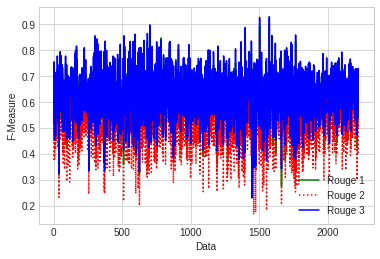

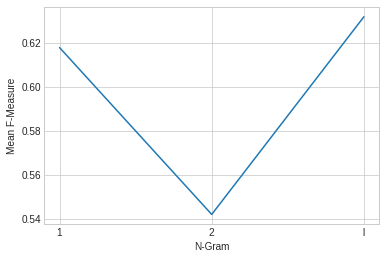

In [0]:
runPerformanceMetric(output_pd)

**Glove word embedding**

Loading glove pre-trained model from **file_path+'glove.840B.300d.txt'**

'glove.840B.300d.txt' can be downloaded from http://nlp.stanford.edu/data/glove.840B.300d.zip 

In [0]:
def loadGlove(location):
    embedding_model = {}
    f = open(location, encoding="utf8")
    for line in f:
        # print(line)
        values = line.split()
        # print(values)
        word = ''.join(values[:-300])
        # print(word)
        word_vectors_300d = np.asarray(values[-300:], dtype='float32')
        embedding_model[word] = word_vectors_300d
    f.close()
    return embedding_model

In [0]:
gloveFile = file_path+'glove.840B.300d.txt'
model = loadGlove(gloveFile)


**FastText word embedding**

Load the pretrained model from **file_path+'wiki.en.bin'**

'wiki.en.bin' can be downloaded from https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip

In [0]:
from gensim.models.wrappers import FastText

model = FastText.load_fasttext_format(file_path+'wiki.en.bin')

**Smooth Inverse Frequency Calculation**


In [0]:
import re;
def count_word_freq(document):
    return Counter(itertools.chain(*document))

def convert_sentence_to_vec(sent_list_tokenized, model, a = 1e-3):
    try:
        word_freq = count_word_freq(sent_list_tokenized)
        sentence_vec=[]
        for sentence in sent_list_tokenized:
            vectors = np.zeros(300)
            sent_length = len(sentence)
            val=0
            for word in sentence:
                if re.match('\w+',word):
                    freq = word_freq[word]
                    denominator = a + freq
                    val += a / denominator # smooth inverse frequency, SIF
            try:
                vectors = np.add(vectors, np.multiply(val, model[word])) # vectors += sif * word_vector
                vectors = np.dot( vectors, model[word])
            except Exception as e:
                pass
            vectors = np.divide(vectors, sent_length) # weighted average
            sentence_vec.append(vectors)
    except Exception as e:
           print("Exception in sentence embedding")
           print(e)
    return sentence_vec

**Pre-processing**

In [0]:
  
lemmatizer = WordNetLemmatizer() 
def text_to_wordlist(text, remove_stopwords=False, stem_words=False, lemma = False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
   

    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Optionally, shorten words to their lemmas
    if lemma:
        text = text.split()
        lemma_words = [lemmatizer.lemmatize(word) for word in text]
        #print('lemmas'+str(lemma_words))
        text = " ".join(lemma_words)
    #print(text)

    # Return a list of words
    return(text)

**Load Data**

In [0]:
import scipy
from scipy.sparse import csr_matrix
output_pd = pd.DataFrame()
output_array = []
i=0
for each_news_article in tqdm(news_summary["ARTICLE"]):
  
  each_news_sentences = []
  nlp = spacy.load('en')

  tokens = nlp(each_news_article)
  for sent in tokens.sents:
      each_news_sentences.append(sent.string.strip())


  sent_list=[]
  for each_sent in each_news_sentences:
      try:
          sent_list.append(word_tokenize(text_to_wordlist(each_sent,False,False,False)))
      except:
        print("error"+each_sent)
  similarity_list=[]
  sent_emb = convert_sentence_to_vec(sent_list,model)
  all_sentence=[]
  for word in (sent_emb):
      current_sentence =[]
      for w in sent_emb:
          cosine = scipy.spatial.distance.cosine(word, w)
          current_sentence.append(round((1-cosine),2))
      all_sentence.append(current_sentence)

  a = np.array(all_sentence, dtype='float32')
  
  similarityScore = csr_matrix(np.array(a))
  rankedList=pagerank(similarityScore, p=0.85)
  output_array.append(sortListOnSimilarity(each_news_sentences,rankedList))

output_pd["OUR_SUMMARY"] = output_array
output_pd["ORIGINAL_SUMMARY"] = news_summary["SUMMARY"]


sent_list=[]


Mean values 0.576963992427098 0.45215296415041684 0.5648131582051903


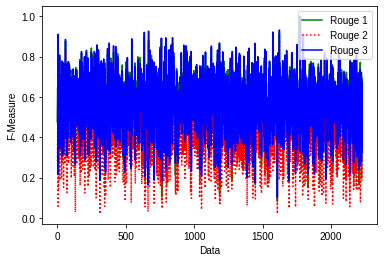

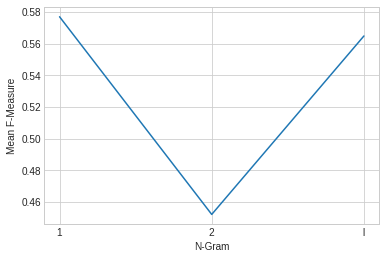

In [0]:
runPerformanceMetric(output_pd)

**Performance of Skip-Thought vectors**

In [0]:
# file_path = '/content/drive/My Drive/NLP_DATA/'
out_summary = pd.read_csv(file_path + 'skipThoughtOutput.csv' , encoding='ISO-8859-1')
output_pd = pd.DataFrame()
output_pd["OUR_SUMMARY"] = out_summary["OUR_SUMMARY"]
output_pd["ORIGINAL_SUMMARY"] = news_summary["SUMMARY"]


Mean values 0.5539111948860177 0.41536524938075065 0.5390562549937548


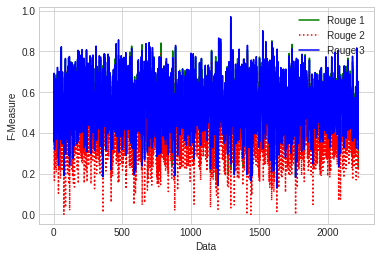

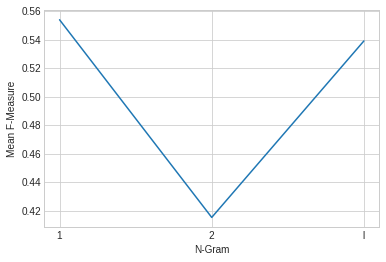

In [0]:
runPerformanceMetric(output_pd)